In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPool1D, Flatten

# sklearn
from sklearn.model_selection import KFold

# Custom
import sys
sys.path.insert(0, '../src/utils')
from data_loader import DataLoader
import constants
sys.path.insert(0, '../src/modeling')
from network import Network
from evaluator import Evaluator

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
BYTE_IDX = 0
# N_CLASSES = 256 ############# look at to_categorical of DataLoader if something goes wrong

train_dl = DataLoader('/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json', BYTE_IDX)
x_train, y_train = train_dl.gen_train() # Default 80% train (40,000 train traces)

Loading the dataset... 
Dataset successfully loaded (55.35 seconds).


In [162]:
def MLP(hp):
    model = Sequential()
    
    # Input
    model.add(Dense(constants.TRACE_LEN,
                    kernel_initializer=hp['kernel_initializer'],
                    activation=hp['activation']))

    # First BatchNorm
    model.add(BatchNormalization())

    # Hidden
    for _ in range(hp['hidden_layers']):
        model.add(Dense(hp['hidden_neurons'],
                        kernel_initializer=hp['kernel_initializer'],
                        activation=hp['activation']))

        # Dropout
        model.add(Dropout(hp['dropout_rate']))
        
        # model.add(BatchNormalization())

    # Second BatchNorm
    model.add(BatchNormalization())

    # Output
    model.add(Dense(256, activation='softmax')) ########################### 256 to be changed if the target is changed (HW, ...)

    # Compilation
    model.compile(optimizer=hp['optimizer'](learning_rate=hp['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


def CNN(hp, input_shape):
    model = Sequential()
    
    model.add(Conv1D(filters=8, 
                     kernel_size=16, 
                     activation='relu',
                     kernel_initializer='random_uniform',
                     input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(pool_size=2))
    
    for _ in range(3):
        model.add(Conv1D(filters=16, 
                         kernel_size=8, 
                         kernel_initializer='random_uniform',
                         activation='relu'))
        model.add(Dropout(0.2))
        # model.add(MaxPool1D(pool_size=2))
    
    model.add(Flatten())
    
    for _ in range(5):
        model.add(Dense(150, activation='relu'))
        
    model.add(Dense(256, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [163]:
mlp_hp = {'kernel_initializer': 'random_uniform',
          'activation':         'relu',
          'hidden_layers':      5,
          'hidden_neurons':     500,
          'dropout_rate':       0.1,
          'optimizer':          RMSprop,
          'learning_rate':      1e-3,
          'batch_size':         100} 

cnn_hp = {}

mlp = MLP(mlp_hp)

cnn_input_shape = (1237, 1) # number of steps of the time series (1237, the number of samples) x number of represented quantities in the time series (1, only the trace signal)
cnn = CNN(cnn_hp, cnn_input_shape)

In [164]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = []
# callbacks.append(EarlyStopping(monitor='val_loss', 
#                                patience=12))
# callbacks.append(ReduceLROnPlateau(monitor='val_loss',
#                                    factor=0.2,
#                                    patience=5,
#                                    min_lr=1e-7))

In [ ]:
x_t = x_train[:37000]
y_t = y_train[:37000]

x_v = x_train[37000:]
y_v = y_train[37000:]

# mlp_history = mlp.fit(x_t, 
#                       y_t,
#                       validation_data=(x_v, y_v),
#                       epochs=50,
#                       batch_size=mlp_hp['batch_size'],
#                       callbacks=callbacks,
#                       verbose=1).history

cnn_history = cnn.fit(x_t, 
                      y_t,
                      validation_data=(x_v, y_v),
                      epochs=100,
                      batch_size=370,
                      callbacks=callbacks,
                      verbose=1).history

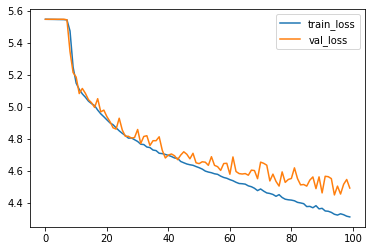

In [166]:
plt.plot(cnn_history['loss'], label='train_loss')
plt.plot(cnn_history['val_loss'], label='val_loss')
plt.legend()
plt.show()

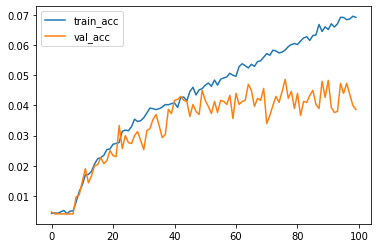

In [167]:
plt.plot(cnn_history['accuracy'], label='train_acc')
plt.plot(cnn_history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
from evaluator import Evaluator

ges = []

for i, device in enumerate(constants.DEVICES):
    for j, key in enumerate(constants.KEYS):
        
        print(f'----- {device}-{key} -----')
        
        if device == 'D1' and key == 'K1':
            path = '/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json'
        else:
            path = f'/prj/side_channel/PinataTraces/datasets/SBOX_OUT/{device}-{key}.json'

        test_dl = DataLoader(path, BYTE_IDX)
        x_test, y_test, pltxt_test = test_dl.gen_test()
        true_key_byte = test_dl.get_true_key_byte()
        
        evaluator = Evaluator(x_test, pltxt_test, true_key_byte, 'MLP')

        ge = evaluator.guessing_entropy(n_exp=10,
                                        hp=hp,
                                        x_train=x_train,
                                        y_train=y_train,
                                        epochs=200)
        
        ges.append(ge)
        
        print()

ges = np.array(ges)

In [ ]:
N = 30

f, ax = plt.subplots(figsize=(15,10))

device = 1
for i, ge in enumerate(ges):
    
    key = i % 3
    
    ax.plot(ge[:N], marker='o', label=f'D{device}-K{key+1}')
    ax.set_title('Training Config: D1-K1')
    ax.set_xlabel('Number of Traces')
    ax.set_ylabel('Guessing Entropy')
    ax.grid()
    _ = ax.set_xticks(range(N))
    
    if key == 2:
        device += 1

plt.plot(np.zeros(N), color='r', ls='--')
plt.grid()
plt.legend()
plt.show()

In [ ]:
import matplotlib.colors as colors

N = 50

f, ax = plt.subplots(len(constants.DEVICES), len(constants.KEYS), figsize=(30,15))

row = 0
for i, ge in enumerate(ges):
    
    col = i % 3
    
    ax[row, col].plot(ge[:N], marker='o', color=list(colors.TABLEAU_COLORS.keys())[i])
    ax[row, col].set_title(f'D{row+1}-K{col+1}')
    ax[row, col].set_xlabel('Number of Traces')
    ax[row, col].set_ylabel('Guessing Entropy')
    ax[row, col].plot(np.zeros(N), color='r')
    ax[row, col].grid()
    # _ = ax[row, col].set_xticks(range(N))
    
    if col == 2:
        row += 1

plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15,10))

device = 1
for i, ge in enumerate(ges):
    
    key = i % 3
    
    ax.plot(ge, label=f'D{device}-K{key+1}')
    ax.set_title('Training Config: D1-K1')
    ax.set_xlabel('Number of Traces')
    ax.set_ylabel('Guessing Entropy')
    ax.grid()
    
    if key == 2:
        device += 1

plt.plot(np.zeros(len(ge)), color='r')
plt.grid()
plt.legend()
plt.show()